In [1]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread
from itertools import product
import random
import tqdm
%matplotlib inline

In [2]:
img = imread("img.png", as_gray=True)
img_shape = img.shape
img = np.round(img)

(394, 392)

In [3]:
mask = np.random.uniform(size=img.shape) < 0.2
noisy_img = img.copy()
noisy_img[mask] = np.abs(noisy_img[mask]-1)

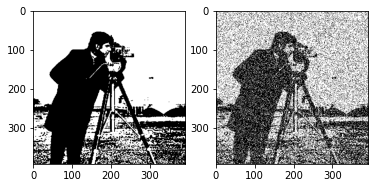

In [4]:
plt.subplot(1, 2, 1)
plt.imshow(img, cmap='gray')
plt.subplot(1, 2, 2)
plt.imshow(noisy_img, cmap='gray')

In [5]:
import torch

In [6]:
def find_neighbors(x, i, j):
    h, w = x.shape
    coords = []
    if i > 0:
        coords.append([i-1, j])
    if j > 0:
        coords.append([i, j-1])
    if i < h - 1:
        coords.append([i+1, j])
    if j < w - 1:
        coords.append([i, j+1])
        
    return torch.Tensor(coords).long()

def total_energy(x, y, h=0, beta=1.0, eta=2.1):
    total_energy = h * x.sum() - eta * (x * y).sum()
    height, width = x.shape
    for i, j in tqdm.tqdm(product(range(height), range(width))):

        coords = find_neighbors(x, i, j)

        neigh_energy = beta * x[i, j] * (x[coords[:, 0], coords[:, 1]]).sum()

        total_energy = total_energy - beta * neigh_energy 
            
    return total_energy

In [7]:
y = torch.from_numpy(noisy_img)*2 - 1
x = y.clone()
height, width = y.shape

h = 0
beta = 1.0
eta = 2.0

In [8]:
E0 = total_energy(x, y, h, beta, eta)

154448it [00:06, 23496.18it/s]


In [9]:
energy_list = [E0]
for k in range(10):
    for i, j in tqdm.tqdm(product(range(height), range(width))):
        coords = find_neighbors(x, i, j)
        neigh_energy = beta * (x[coords[:, 0], coords[:, 1]]).sum()
        pos_energy = h - eta * y[i, j] - 2 * neigh_energy
        neg_energy = -h + eta * y[i, j] + 2 * neigh_energy

        if pos_energy < neg_energy:
            x[i, j] = 1
        else:
            x[i, j] = -1
    E = total_energy(x, y, h, beta, eta)
    if E / energy_list[-1] - 1 < 1e-5:
        break
        
    energy_list.append(E)

154448it [00:13, 11132.33it/s]
154448it [00:07, 21845.33it/s]
154448it [00:15, 9771.66it/s] 
154448it [00:06, 23673.10it/s]
154448it [00:15, 10015.30it/s]
154448it [00:06, 22473.23it/s]
154448it [00:13, 11502.34it/s]
154448it [00:07, 21678.59it/s]
154448it [00:13, 11561.97it/s]
154448it [00:06, 24860.52it/s]
154448it [00:14, 10865.10it/s]
154448it [00:07, 21726.39it/s]
154448it [00:14, 10917.48it/s]
154448it [00:06, 22817.87it/s]


In [25]:
import matplotlib
matplotlib.rcParams.update({
    'font.size': 15,
    'font.family': 'Arial',
    'axes.titlepad': 15,
    'axes.titlesize': 20
})

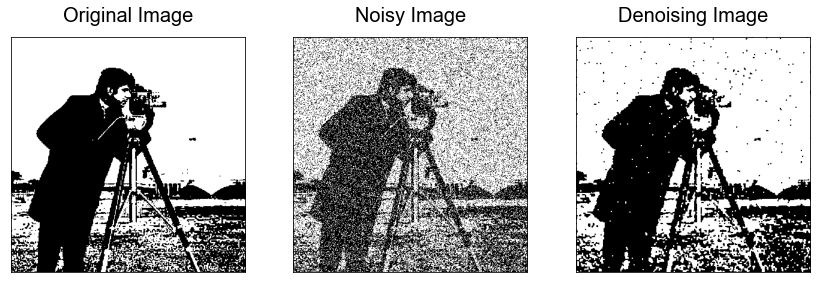

In [28]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.imshow(img, cmap='gray')
plt.title('Original Image')
plt.xticks([])
plt.yticks([])
plt.subplot(1, 3, 2)
plt.xticks([])
plt.yticks([])
plt.title('Noisy Image')
plt.imshow(noisy_img, cmap='gray')
plt.subplot(1, 3, 3)
plt.xticks([])
plt.yticks([])
plt.title('Denoising Image')
plt.imshow(x, cmap='gray')
plt.tight_layout()
plt.savefig('image-denoising.png')